# <p style="background-color:#CCE3F2; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">Goal : Predict if a passenger can survive on the titanic or not.
</p>

<p style="background-color:#CCE3F2; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 100px;"><a id="outlines">Feel free to share your ideas with me.</a></p>

<p style="background-color:#CCE3F2; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 100px;"><a id="outlines">Outlines : </a></p>
<ul>
    <li><a href="#1.0"><b>1.Imports</b></a>
    <li><a href="#2.0"><b>2.Kaggle  preparing commands</b></a>
    <li><a href="#3.0"><b>3.Functions</b></a>
    <li><a href="#4.0"><b>4.Read and clean train data</b></a>
    <li><a href="#5.0"><b>5.Encode categorical data</b></a>
    <li><a href="#6.0"><b>6.Some info about data and visualizations</b></a>
    <li><a href="#7.0"><b>7.PCA</b></a>
    <li><a href="#8.0"><b>8.Classifiers</b></a>
    <li><a href="#9.0"><b>9.Load test data</b></a>
        
</ul>

<p style="background-color:#CCE3F2; font-family:newtimeroman; font-size:200%; text-align:center; border-radius: 10px 100px;"><a id="outlines">References : </a></p>

https://stackoverflow.com/questions/43355044/cumulative-explained-variance-for-pca-in-python

https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe

https://stackoverflow.com/questions/23294616/how-to-use-scikit-learn-pca-for-features-reduction-and-know-which-features-are-d

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

https://www.geeksforgeeks.org/create-a-pandas-dataframe-from-lists/

https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning

https://www.kaggle.com/khkuggle/simple-and-intermediate-eda-modeling-for-titanic for some visualizations

https://www.kaggle.com/alaasedeeq/object-oriented-programming-for-data-science for outlines and markdown

<a id="1.0"></a>
<h1>1.Imports</h1>

In [126]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import copy
import time
from math import sqrt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.svm import SVR,SVC
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB,GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from rgf.sklearn import RGFClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder

import warnings
warnings.simplefilter(action='ignore', category=Warning)

<a id="2.0"></a>
<h1>2.Kaggle  preparing commands</h1>

In [127]:
# !mkdir data
# !cp /kaggle/input/titanic/train.csv ./data/train.csv
# !cp /kaggle/input/titanic/test.csv ./data/test.csv

<a id="3.0"></a>
<h1>3.Functions</h1>

In [128]:
def execution_time_calculator(start_time):
    delta = time.time() - start_time
    print("--- %s seconds ---" % (delta))
    

# def df_clean(df):
#     df["date"] = df["date"].apply(time_to_standard)
#     df = df.drop_duplicates(subset=['date'])
#     dropped_df = df.dropna(axis=1).dropna().drop(['unix', 'symbol'], axis=1)  
#     return dropped_df


def plot_train_data(df):
    for col in df.columns :
        plt.figure(figsize=(10, 5))
        sns.distplot(df[col])
        plt.title(col)
#     plt.plot(df.index, df['Age'])

#     plt.show()
    return None


def df_clean(df,mode=0,pre_found_age_value=0):
    if mode==0:
        age_mean = df.mean(axis=0)[3]
    elif mode==1:
        age_mean = pre_found_age_value
    
    values = {"Age": age_mean, "Cabin": "-", "Embarked": "-","Pclass":0,"Sex":"male","SibSp":0,"Parch":0,"Ticket":"-","Fare":0}
    df = df.fillna(value=values)
    # df = df[['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked", "Survived"]]
    if mode==0:
#         df = df
        df = df[['Pclass', 'Sex', 'Age', "SibSp", "Parch", "Fare", "Cabin", "Embarked", "Survived"]]
    elif mode==1:
        df = df[['Pclass', 'Sex', 'Age', "SibSp", "Parch", "Fare", "Cabin", "Embarked"]]

    return df,age_mean

def df_encoder(df,mode=0,LEs=None):
    if mode==0:
        LE_Sex = LabelEncoder()
        LE_Cabin = LabelEncoder()
        LE_Embarked = LabelEncoder()
    elif mode==1:
        LE_Sex = LEs[0]
        LE_Cabin = LEs[0]
        LE_Embarked = LEs[0]
    
    df['Sex'] = LE_Sex.fit_transform(df['Sex'])
    df['Cabin'] = LE_Cabin.fit_transform(df['Cabin'])
    df['Embarked'] = LE_Embarked.fit_transform(df['Embarked'])
    
    return df, LE_Sex, LE_Cabin, LE_Embarked


def metrics_calculator(real,pred,mode):
    print("********",mode,"********",":")
    metrics_lists=[metrics.accuracy_score,metrics.f1_score,metrics.precision_score,metrics.recall_score,metrics.average_precision_score,metrics.roc_auc_score,metrics.mean_squared_error,metrics.mean_squared_error]
    metric_names=["Accuracy","F1","Precision","Recall","AP","RoC_AuC","MSE"]
    for metric in range(len(metrics_lists)):
        if metric== len(metrics_lists)-1:
            metric_value = metrics_lists[metric](real, pred)
            print("{:20}".format("{}: ".format("RMSE")),sqrt(metric_value))
        else:  
            metric_value = metrics_lists[metric](real, pred)
            print("{:20}".format("{}: ".format(metric_names[metric])),metric_value)
        
#     report = classification_report(real, pred)
#     print(report)


    
def all_models_test(df,models,models_name,x_train,y_train):

    classifiers = []
    for i in range(len(models)):
        print("--------",models_name[i],"--------")
        clf = models[i].fit(x_train, y_train)
        y_pred_train = clf.predict(x_train)
        metrics_calculator(y_pred_train,y_train,"train")
        classifiers.append(clf)
    return classifiers

<a id="4.0"></a>
<h1>4.Read and clean train data</h1>

In [129]:
df = pd.read_csv("./data/train.csv")#,skiprows=1)#.iloc[::-1].reset_index().drop(["index"], axis=1)

In [130]:
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [114]:
df_clean,age_mean = df_clean(df)

In [115]:
df_clean.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,male,22.0,1,0,7.2500,-,S,0
1,1,female,38.0,1,0,71.2833,C85,C,1
2,3,female,26.0,0,0,7.9250,-,S,1
3,1,female,35.0,1,0,53.1000,C123,S,1
4,3,male,35.0,0,0,8.0500,-,S,0


<a id="5.0"></a>
<h1>5.Encode categorical data</h1>

In [116]:
df_encoded, LE_Sex, LE_Cabin, LE_Embarked = df_encoder(df_clean)


# pandas encoding - not good when we want to apply on test data

# df['Sex'] = df['Sex'].astype('category')
# df['Cabin'] = df['Cabin'].astype('category')
# df['Embarked'] = df['Embarked'].astype('category')
# OneHotEncoder().fit_transform(df)
# cat_columns = df.select_dtypes(['category']).columns
# df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

In [117]:
df_encoded.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,1,22.0,1,0,7.2500,0,3,0
1,1,0,38.0,1,0,71.2833,82,1,1
2,3,0,26.0,0,0,7.9250,0,3,1
3,1,0,35.0,1,0,53.1000,56,3,1
4,3,1,35.0,0,0,8.0500,0,3,0


In [118]:
# df_encoded.info()

In [119]:
array = df_encoded.values
X = array[:,:-1]
Y = array[:,-1]

<a id="6.0"></a>
<h1>6.Some info about data and visualizations</h1>

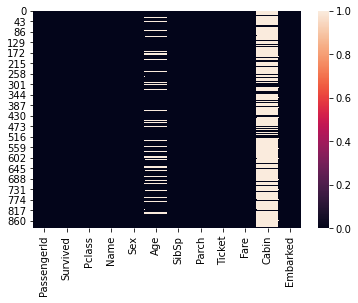

In [120]:
# plot na fields
sns.heatmap(df.isna());

In [121]:
df_clean.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int32  
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Cabin     891 non-null    int32  
 7   Embarked  891 non-null    int32  
 8   Survived  891 non-null    int64  
dtypes: float64(2), int32(3), int64(4)
memory usage: 52.3 KB


In [122]:
# print(df_clean["Cabin"].unique())
# print(df_clean["Cabin"].describe())
# print(df_clean.describe())
# print(df_clean["Cabin"].value_counts())
# print(df_clean['Embarked'].value_counts().idxmax())
# sns.countplot(x='Embarked',data=df_clean,palette='Set2')

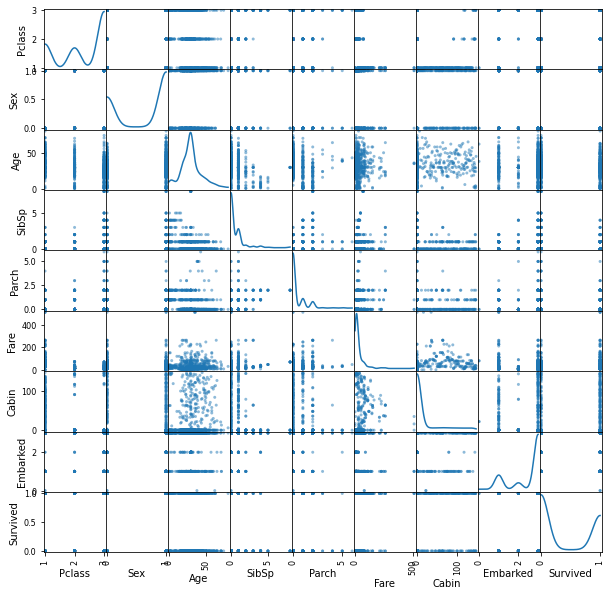

In [106]:
pd.plotting.scatter_matrix(df_clean, diagonal='kde', figsize=(10, 10));

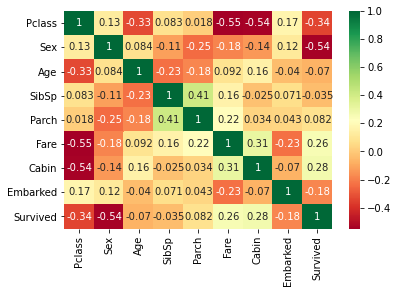

In [107]:
sns.heatmap(df_clean.corr(),annot=True,cmap="RdYlGn");

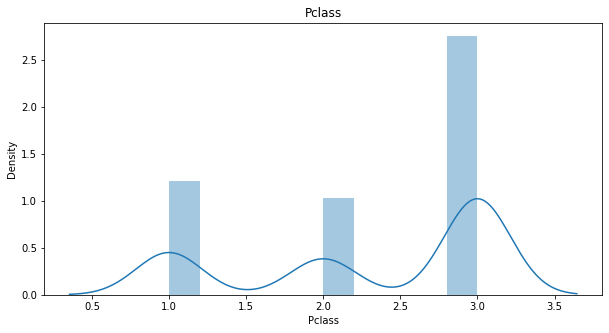

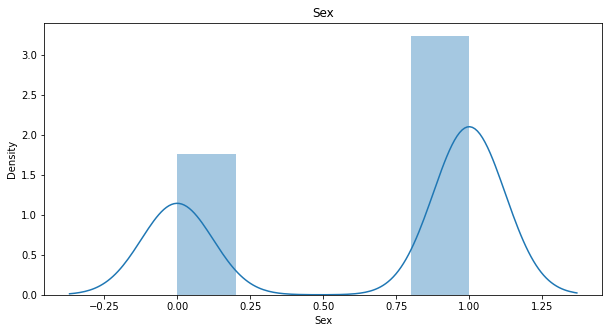

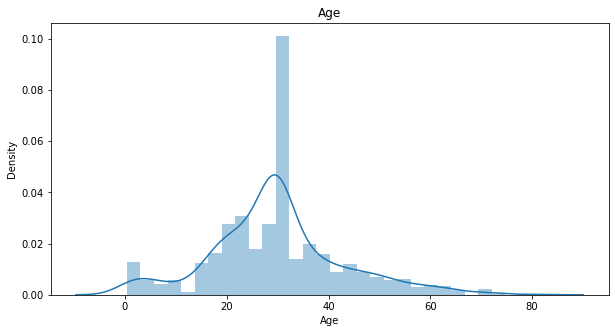

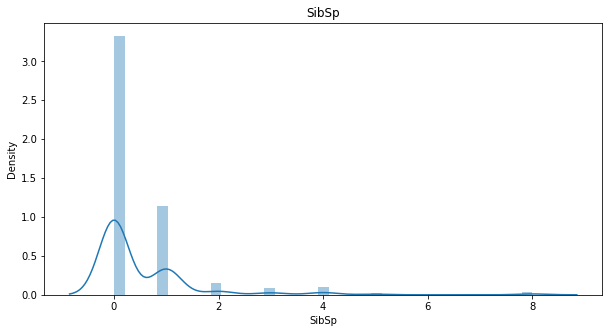

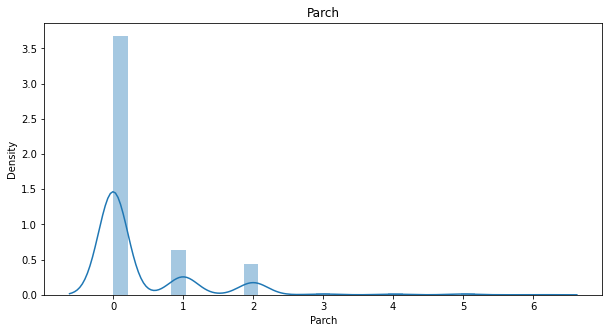

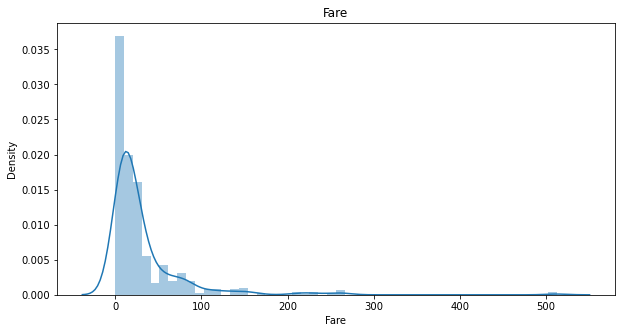

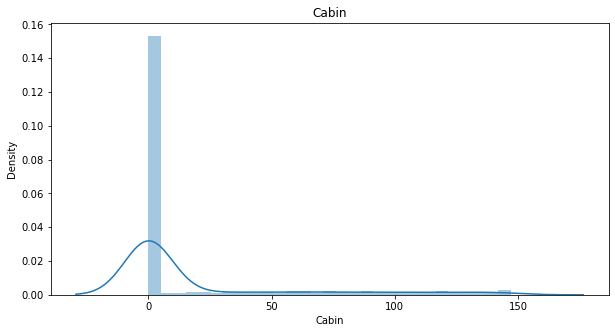

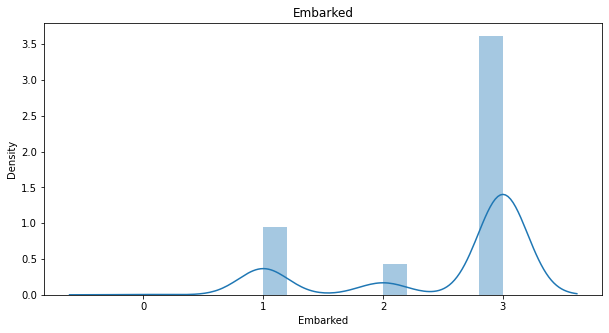

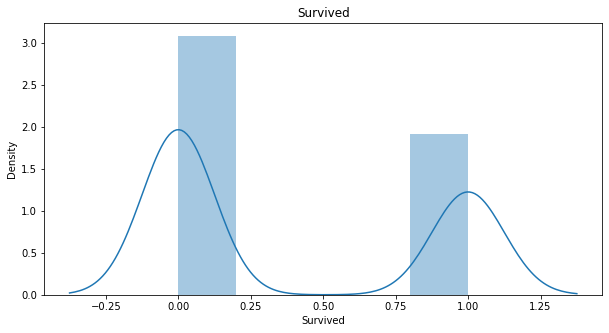

In [108]:
plot_train_data(df_encoded);

<a id="7.0"></a>
<h1>7.PCA</h1>

In [79]:
pca = PCA(n_components=6)
fit = pca.fit(X)
# summarize components
explained_variance_ratio=fit.explained_variance_ratio_

print(explained_variance_ratio)
print(len(explained_variance_ratio))
print(sum(explained_variance_ratio))
x_pca_train = pca.transform(X)
y_train = Y
x_train = X

[6.69591682e-01 2.89634969e-01 4.00730257e-02 3.10136191e-04
 1.45071161e-04 1.14935589e-04]
6
0.9998698193599477


<a id="8.0"></a>
<h1>8.Classifiers</h1>

In [123]:
BNB = BernoulliNB()
GNB = GaussianNB()
RF = RandomForestClassifier()
DTree = DecisionTreeClassifier()
KNN = KNeighborsClassifier()
LR = LogisticRegression()
MLP = make_pipeline(MinMaxScaler(), MLPClassifier(random_state=0, shuffle=False))
XGB = xgb.XGBClassifier(eval_metric='mlogloss')
SVC_auto = make_pipeline(MinMaxScaler(), SVC(gamma="auto"))
RGF = RGFClassifier()
Bagging = BaggingClassifier(random_state=0)
estimators = [
   ('xgb', xgb.XGBClassifier(eval_metric='mlogloss')),
   ('lr', LogisticRegression()),
   ('nb', BernoulliNB()),
   ('rgf', RGFClassifier()),
   ('svm', make_pipeline(StandardScaler(), SVC(gamma="auto"))),
   ('mlp', make_pipeline(StandardScaler(), MLPClassifier(random_state=0, shuffle=False))),
]
Voting = VotingClassifier(estimators)
Stacking = StackingClassifier(estimators, LogisticRegression())
custom_RF=RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=6, min_samples_leaf=6, warm_start=True)

models = [BNB,GNB,RF,custom_RF,DTree,KNN,LR,MLP,XGB,SVC_auto,RGF,Bagging,Voting,Stacking]
models_name = ["BNB","GNB","RF","custom_RF","DTree","KNN","LR","MLP","XGB","SVC_auto","RGF","Bagging","Voting","Stacking"]


In [124]:
start_time = time.time()

classifiers = all_models_test(df_encoded,models[:],models_name,x_train,y_train)

execution_time_calculator(start_time)

-------- BNB --------
******** train ******** :
Accuracy:            0.7856341189674523
F1:                  0.7203513909224013
Precision:           0.7192982456140351
Recall:              0.7214076246334311
AP:                  0.6255290120598553
RoC_AuC:             0.7734310850439883
MSE:                 0.2143658810325477
RMSE:                0.46299663177235717
-------- GNB --------
******** train ******** :
Accuracy:            0.7991021324354658
F1:                  0.7316341829085456
Precision:           0.7134502923976608
Recall:              0.7507692307692307
AP:                  0.6265456181245654
RoC_AuC:             0.7888121772220713
MSE:                 0.20089786756453423
RMSE:                0.44821631782492505
-------- RF --------
******** train ******** :
Accuracy:            0.9865319865319865
F1:                  0.9823008849557523
Precision:           0.9736842105263158
Recall:              0.9910714285714286
AP:                  0.9683576048707628
RoC_AuC:      

<a id="9.0"></a>
<h1>9.Load test data</h1>

In [19]:
df_test = pd.read_csv("./data/test.csv")

In [20]:
# df_test.info()
# df_test

In [21]:
ids_col = df_test["PassengerId"].values
df_test,_ = df_clean(df_test,1,age_mean)
df_test,_,_,_ = df_encoder(df_test,1,[LE_Sex, LE_Cabin, LE_Embarked])

array_test = df_test.values
x_test = array_test[:,]

In [25]:
def predict_one_classifier(classifier,x_test):
    y_pred_test = classifier.predict(x_test)
#     metrics_calculator(labels_col,y_pred_test,"test")
    return y_pred_test

def predic_with_all_classifiers(classifiers,x_test):
    for i in range(len(classifiers)):
        predict_one_classifier(classifiers[i],x_test)

In [26]:
# predic_with_all_classifiers(classifiers,x_test)
y_pred_test = predict_one_classifier(classifiers[9],x_test)

In [27]:
df_result = pd.DataFrame(list(zip(list(ids_col),list(y_pred_test))), columns =['PassengerId','Survived'])
df_result['Survived'] = df_result['Survived'].astype('int64')

In [24]:
# df_result

In [ ]:
# compression_opts = dict(method='zip',archive_name='out.csv')  

df_result.to_csv('out.csv', index=False)  